In [4]:
cd /data/convchess/src/play/

/data/convchess/src/play


In [5]:
import keras
import cPickle as pkl
import sys
import numpy as np
sys.setrecursionlimit(40000)
class CNN_evaluator:
	"""docstring for CNN_evaluation"""
	def __init__(self, model_file):
		self.model = pkl.load(open(model_file, 'r'))

	def evaluate(self, im):
		return self.model.predict(np.asarray([im]), verbose=0)[0][0]

	def evaluate_batch(self, batch):
		#batch is much faster than one individually
		#print batch
		return self.model.predict(np.asarray(batch), verbose=0, batch_size=2048)[:,0]

In [6]:
evaluator = CNN_evaluator('regression_models/fics_g07_3.pkl')

In [7]:
from play4 import *
import sunfish
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
bb = pos_board_to_bitboard(pos.board)
print bb
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1. -1. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[-1.  0.  0.  0.  0.  0.  0. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0. -1.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  1.  0

In [8]:
print "Evaluation of the starting board %f"%evaluator.evaluate(im)

Evaluation of the starting board 0.014606


In [9]:
from example_moves.draw_board.draw import *

In [10]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


In [11]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im,2,0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.xticks(range(8), string.lowercase)
    ax = plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r)
    f = plt.gcf()
    f.set_size_inches(6,6)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.show()
def im_to_boardimage(im):
    plt.xticks(range(8), string.lowercase)
    ax = plt.imshow(draw_board(im), cmap=cm.Greys_r)
    f = plt.gcf()
    f.set_size_inches(6,6)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.show()

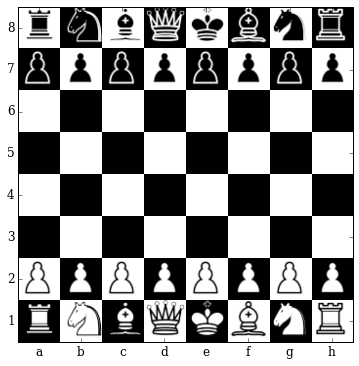

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rc('text', usetex=False, antialiased=True, hinting='auto', dvipnghack=True)
plt.rc('font', family='serif', size=12)
image_board(pos.board)

In [13]:
def top_bottom_moves(fen, top=5, bottom=5):
    pos = parseFEN(fen)
    bb = pos_board_to_bitboard(pos.board)
    image_board(pos.board)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im, 2, 0)
    print "\tCurrent evaluation: %f"%evaluator.evaluate(im)
    future_boards = []
    pos_children = []
    moves = list(pos.genMoves())
    print "Total %d moves possible"%len(moves)
    for move in moves:
        pos_child = pos.move(move).rotate()
        bb = pos_board_to_bitboard(pos_child.board)
        im = convert_bitboard_to_image(bb)
        im = np.rollaxis(im, 2, 0)
        future_boards.append(im)
        pos_children.append(pos_child.board)
    #future_boards = np.asarray(future_boards)
    values = evaluator.evaluate_batch(future_boards)
    poschildren_vals = sorted(zip(pos_children , moves, values), key=operator.itemgetter(2), reverse=True)
    print "TOP 5 Moves"
    for pos_child, move, value in poschildren_vals[0:top]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 
    print "WORST 5 Moves"
    for pos_child, move, value in poschildren_vals[-bottom:]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 

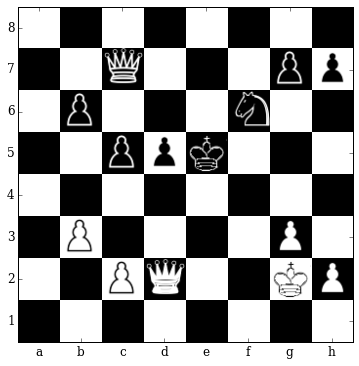

Value of the table: -4


In [14]:
'''
Piece	pawn	knight	bishop	rook	queen
Value	1	3	3	5	9
'''
fen='8/2q3pp/1p3n2/2ppk3/8/1P4P1/2PQ2KP/8 w - - 0 0'
im = fen_to_im(fen)
pos = parseFEN(fen)
image_board(pos.board)
layer_scores=np.array([1,5,3,3,9,100])
def fen_to_tableval(fen):
    im = fen_to_im(fen)
    return im_to_tableval(im)
def im_to_tableval(im):
    #for a 6 layer representation
    return np.sum(np.sum(im,(1,2))*layer_scores)
print "Value of the table: %d"%im_to_tableval(im)

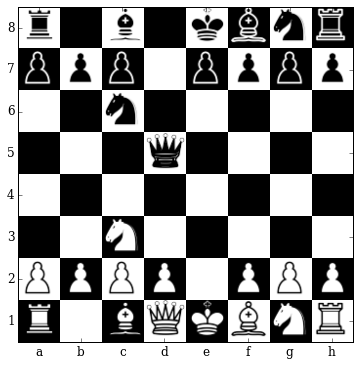

	Current evaluation: 0.003406
Total 32 moves possible
TOP 5 Moves


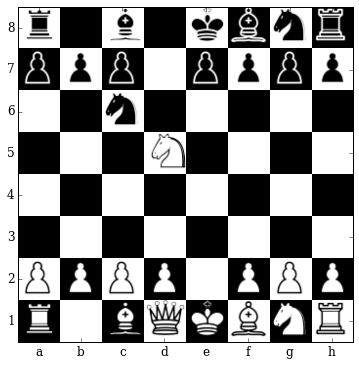

	c3d5 0.0545512884855


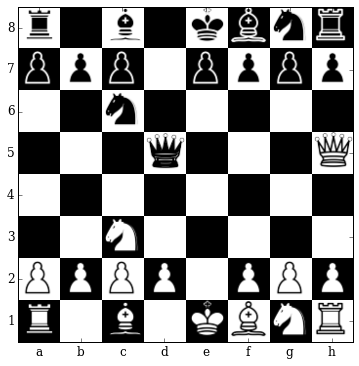

	d1h5 0.0144034344703


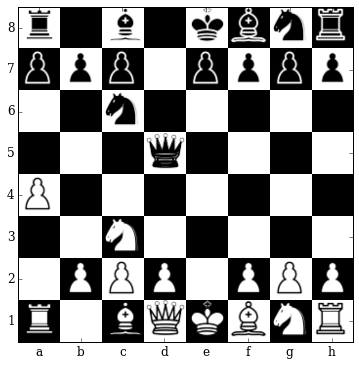

	a2a4 0.0119769489393


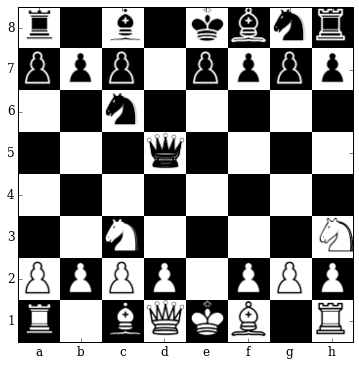

	g1h3 0.0115632014349


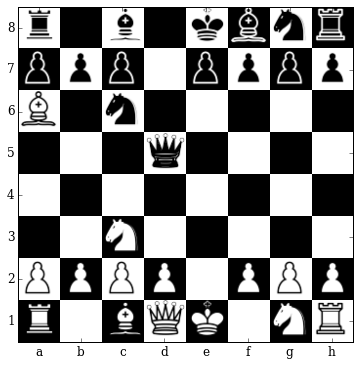

	f1a6 0.0110727213323
WORST 5 Moves


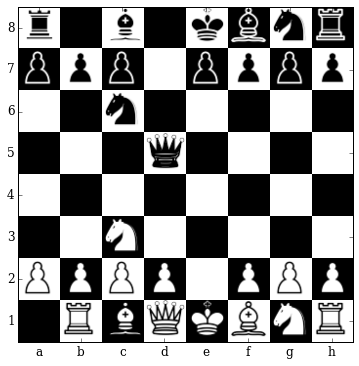

	a1b1 -0.000657647731714


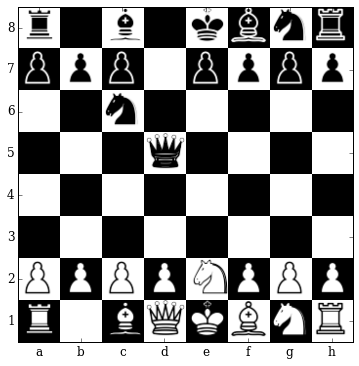

	c3e2 -0.00339175574481


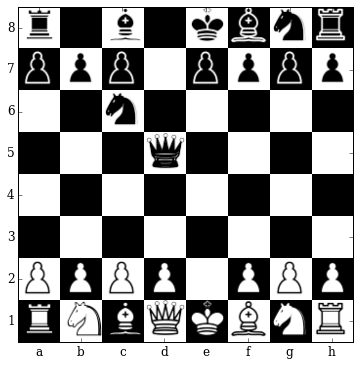

	c3b1 -0.00497450307012


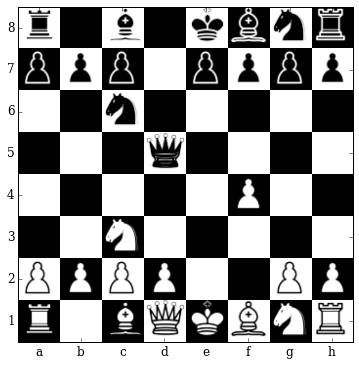

	f2f4 -0.00507036363706


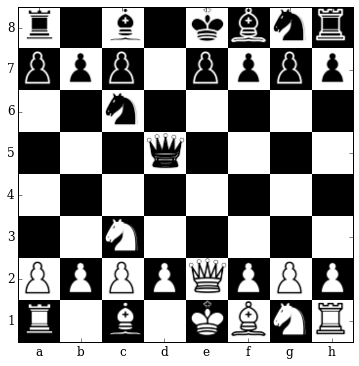

	d1e2 -0.00937258545309


In [13]:
'''
Killing Queen with a knight
(Works)
'''
top_bottom_moves('r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4')

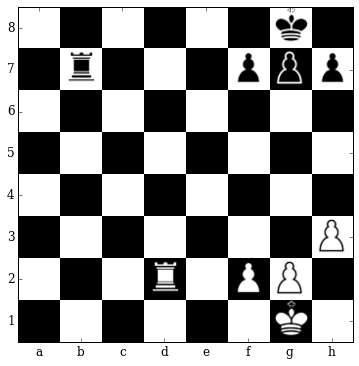

	Current evaluation: -0.006740
Total 19 moves possible
TOP 5 Moves


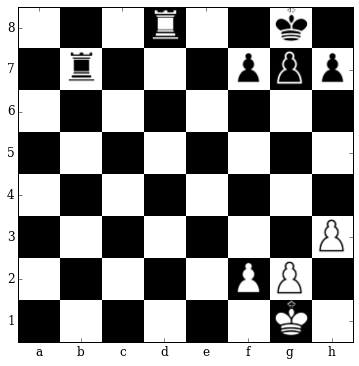

	d2d8 0.0452536605299


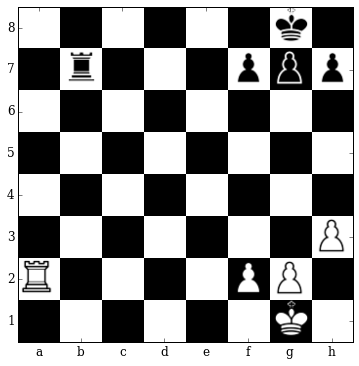

	d2a2 0.0176544804126


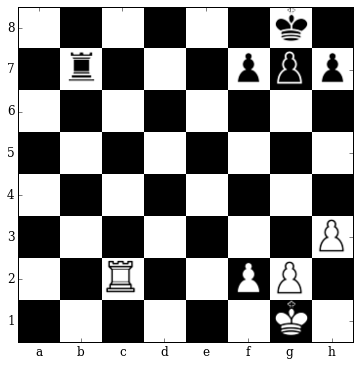

	d2c2 0.00976785086095


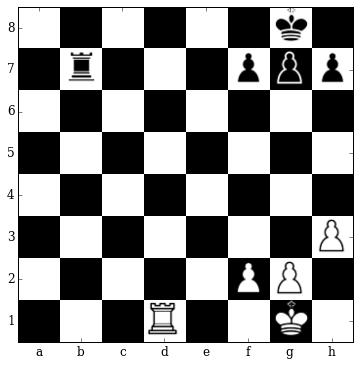

	d2d1 0.00954846478999


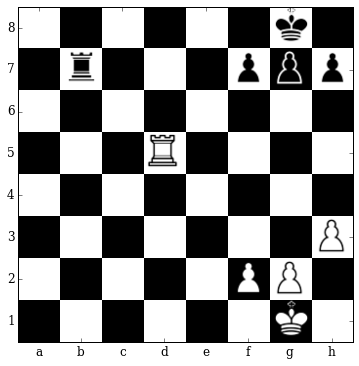

	d2d5 0.00700665730983
WORST 5 Moves


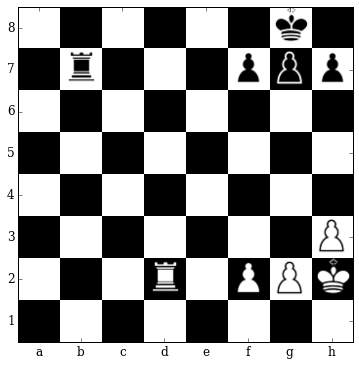

	g1h2 -0.0147265279666


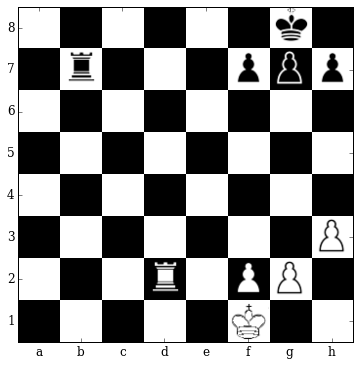

	g1f1 -0.0185413267463


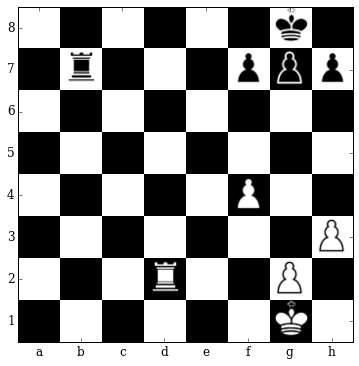

	f2f4 -0.0185624714941


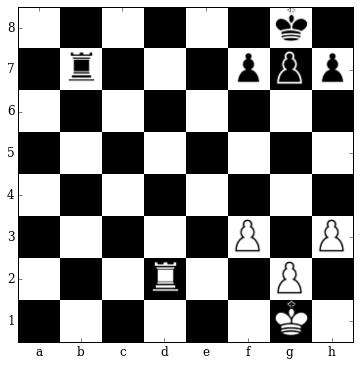

	f2f3 -0.0199430584908


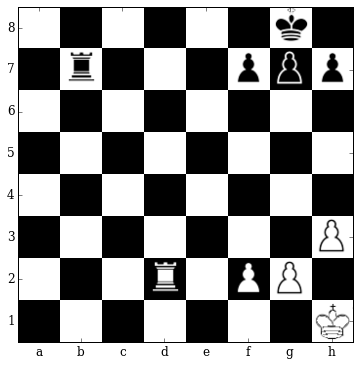

	g1h1 -0.0221134386957


In [14]:
'''
Checkmating with a rook
(Works)
'''
top_bottom_moves('6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0')

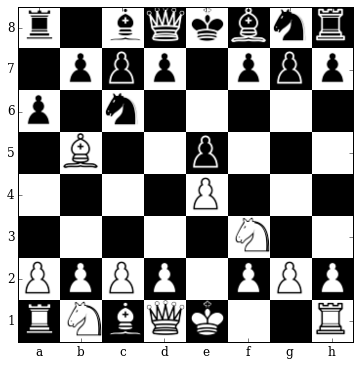

	Current evaluation: -0.003171
Total 32 moves possible
TOP 5 Moves


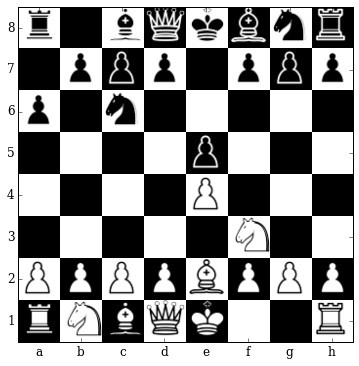

	b5e2 0.00623769778758


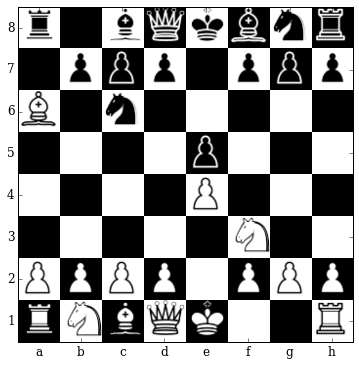

	b5a6 0.00556590827182


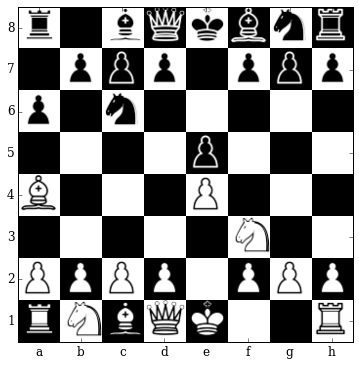

	b5a4 0.00405460782349


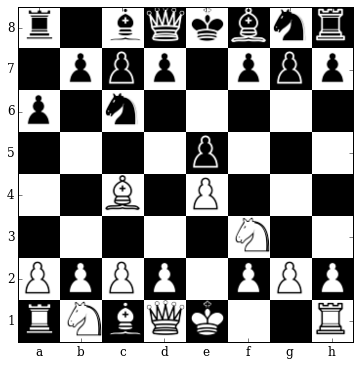

	b5c4 0.00325289717875


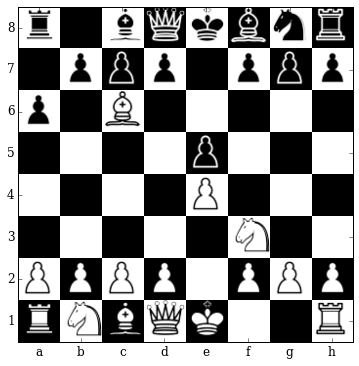

	b5c6 0.00300058745779
WORST 5 Moves


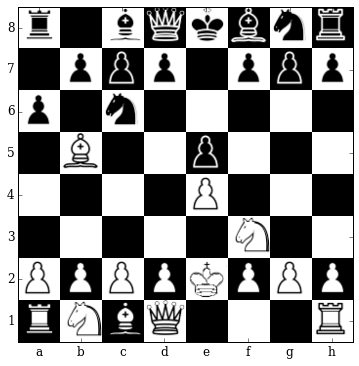

	e1e2 -0.00794988125563


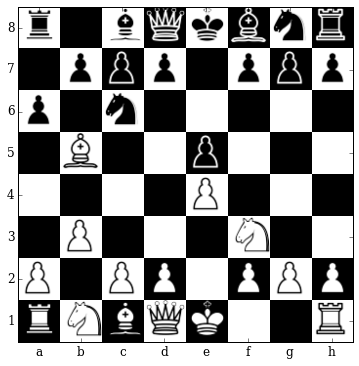

	b2b3 -0.00797471962869


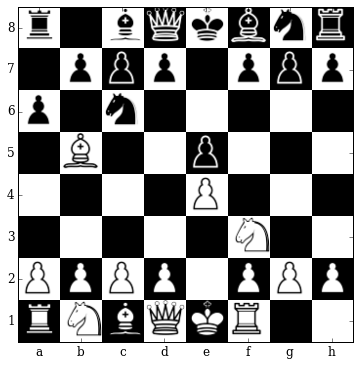

	h1f1 -0.00896198488772


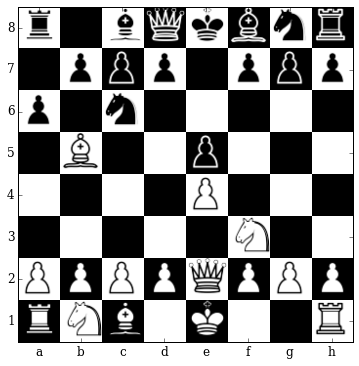

	d1e2 -0.0102248834446


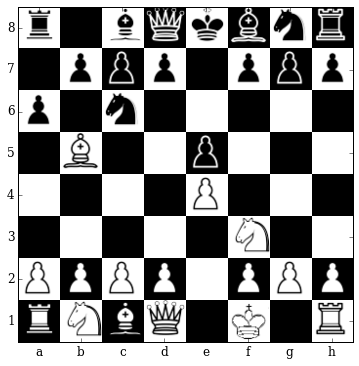

	e1f1 -0.0129785845056


In [15]:
'''
 Trading the knight with a bishop
'''
top_bottom_moves('r1bqkbnr/1ppp1ppp/p1n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0')

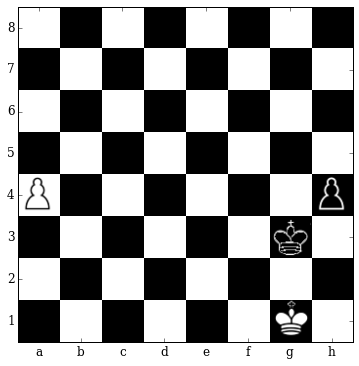

	Current evaluation: -0.049161
Total 6 moves possible
TOP 5 Moves


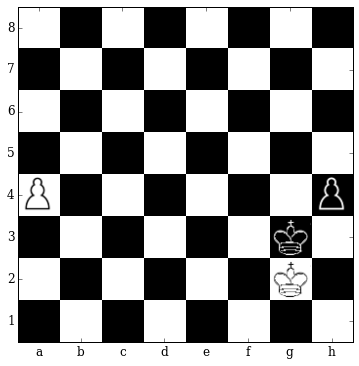

	g1g2 0.00462216185406


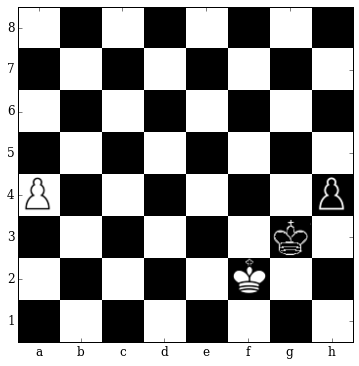

	g1f2 -0.0209280643612


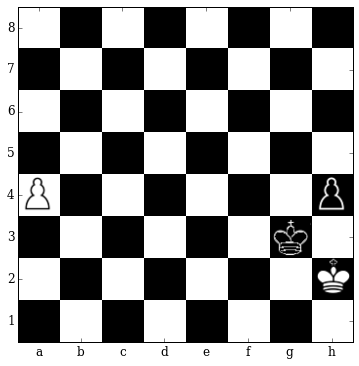

	g1h2 -0.0317683890462


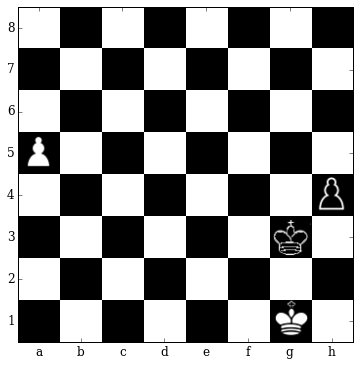

	a4a5 -0.0482270270586


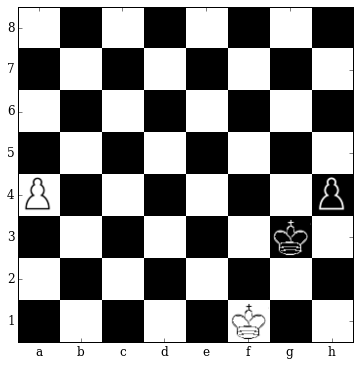

	g1f1 -0.0665239691734
WORST 5 Moves


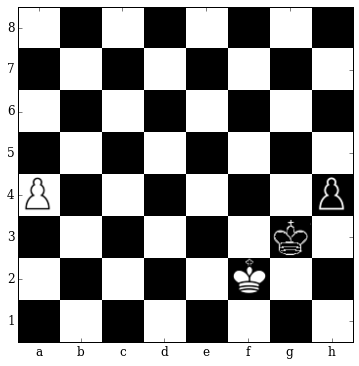

	g1f2 -0.0209280643612


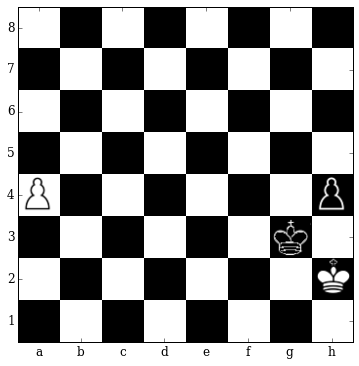

	g1h2 -0.0317683890462


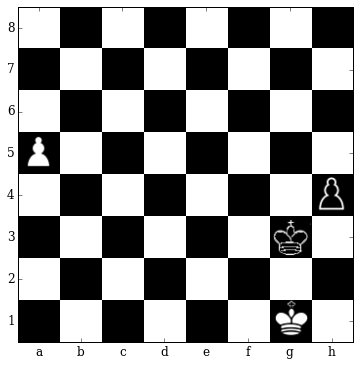

	a4a5 -0.0482270270586


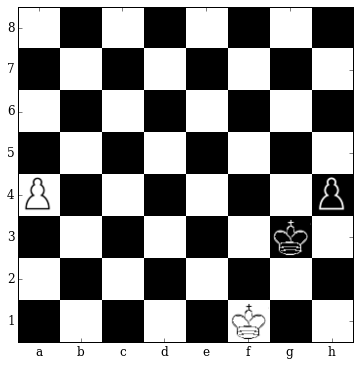

	g1f1 -0.0665239691734


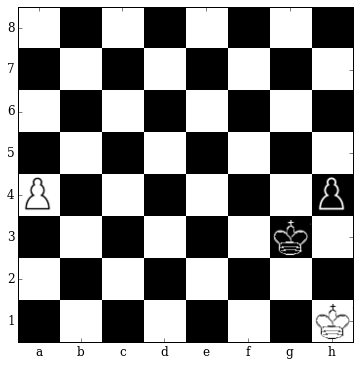

	g1h1 -0.0737288221717


In [16]:
'''
Runaway Pawn
'''
top_bottom_moves('8/8/8/8/P6p/6k1/8/6K1 w - - 0 0')

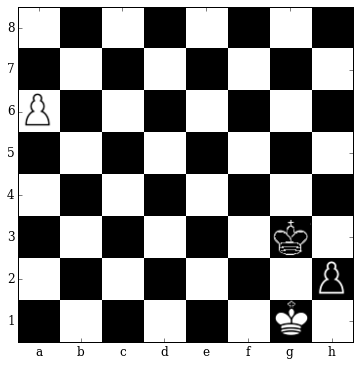

	Current evaluation: -0.049778
Total 6 moves possible
TOP 5 Moves


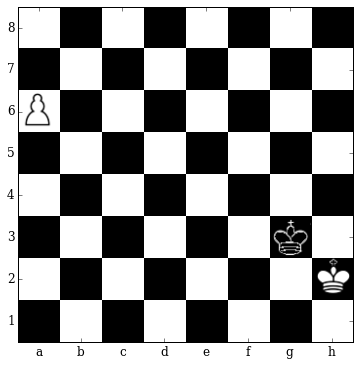

	g1h2 0.0215898770839


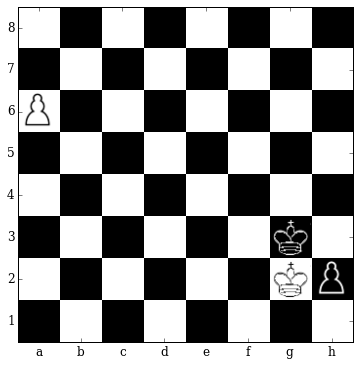

	g1g2 0.00836602784693


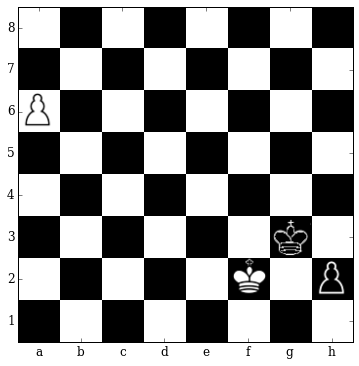

	g1f2 -0.0188560783863


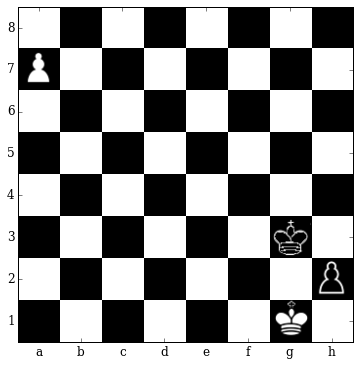

	a6a7 -0.054150197655


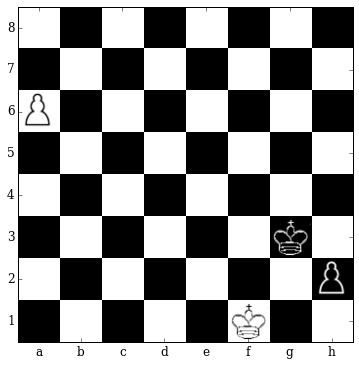

	g1f1 -0.065742097795
WORST 5 Moves


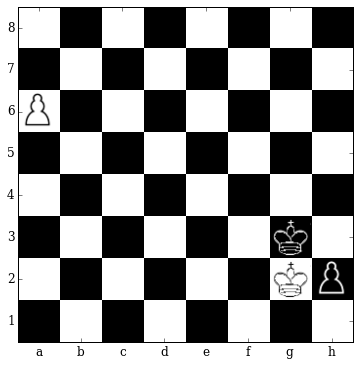

	g1g2 0.00836602784693


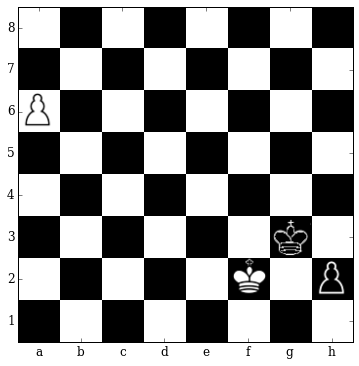

	g1f2 -0.0188560783863


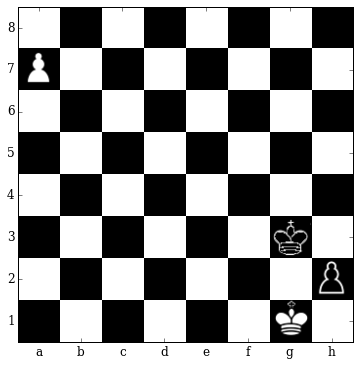

	a6a7 -0.054150197655


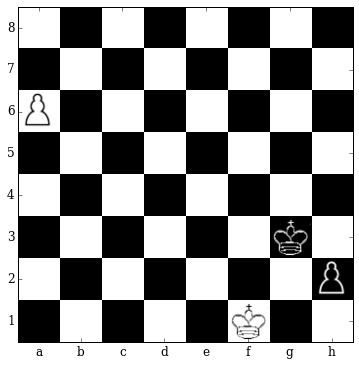

	g1f1 -0.065742097795


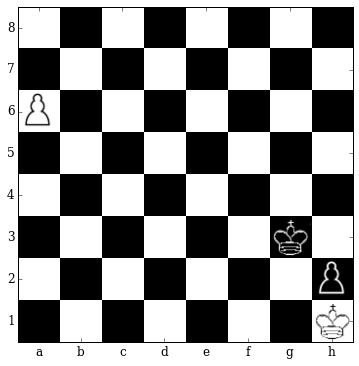

	g1h1 -0.0684899687767


In [17]:
'''
Check and Blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
top_bottom_moves(fen)

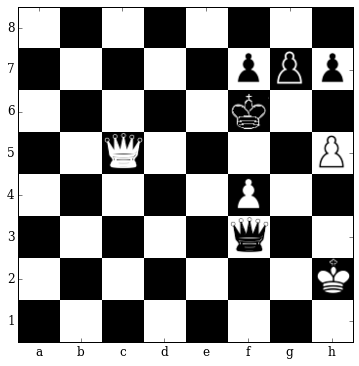

	Current evaluation: -0.067688
Total 31 moves possible
TOP 5 Moves


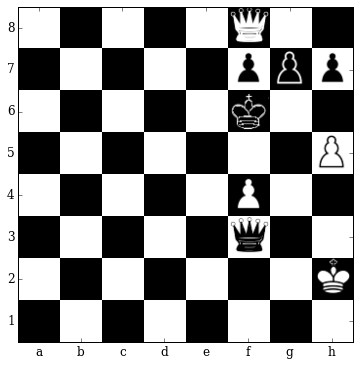

	c5f8 0.0379827916622


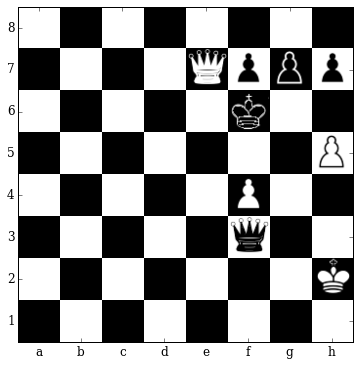

	c5e7 0.028200475499


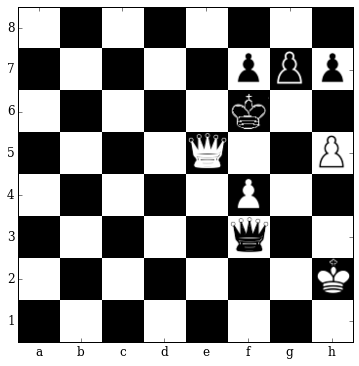

	c5e5 -0.0355458073318


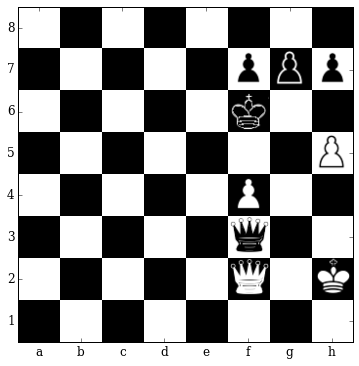

	c5f2 -0.0388837084174


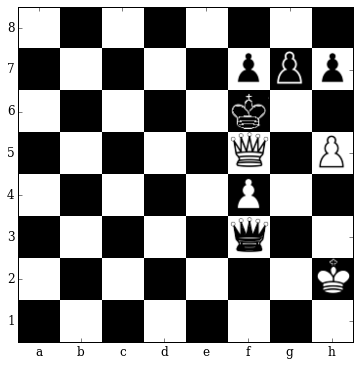

	c5f5 -0.0413541197777
WORST 5 Moves


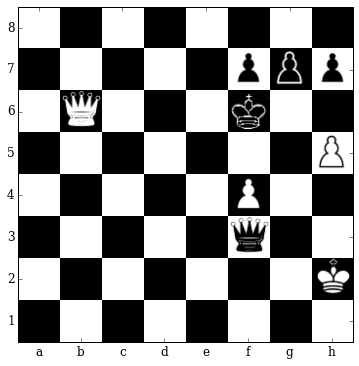

	c5b6 -0.0826028212905


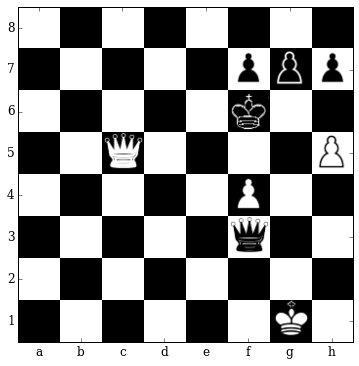

	h2g1 -0.0835127830505


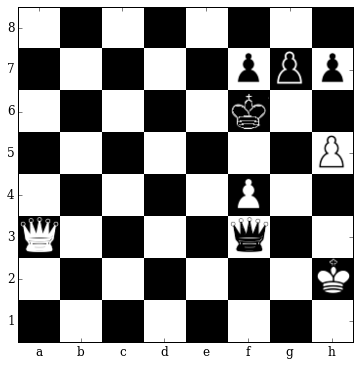

	c5a3 -0.0964041724801


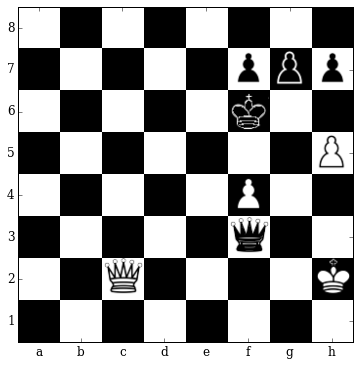

	c5c2 -0.111014157534


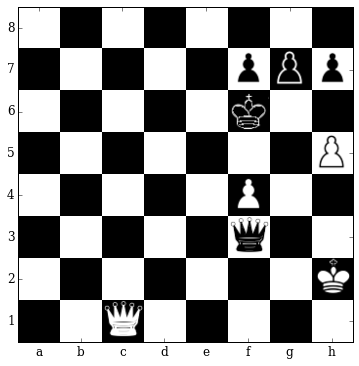

	c5c1 -0.129943683743


In [18]:
'''
Mate in 1
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
top_bottom_moves(fen)

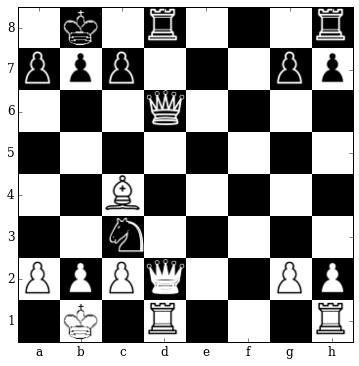

	Current evaluation: -0.007698
Total 41 moves possible
TOP 5 Moves


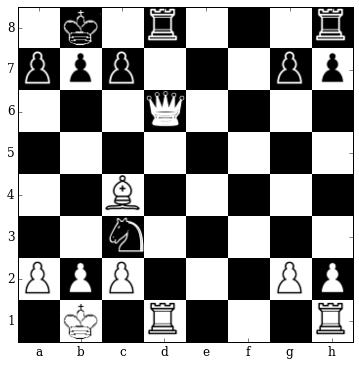

	d2d6 0.139244303107


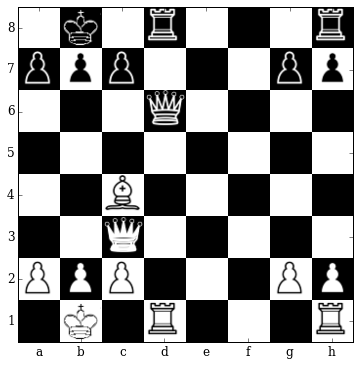

	d2c3 0.0400848388672


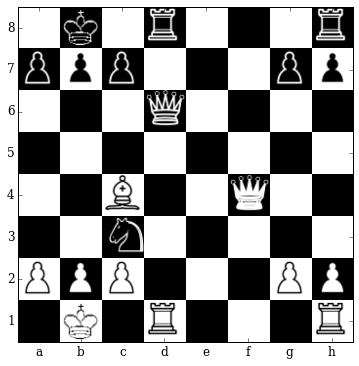

	d2f4 0.0280776247382


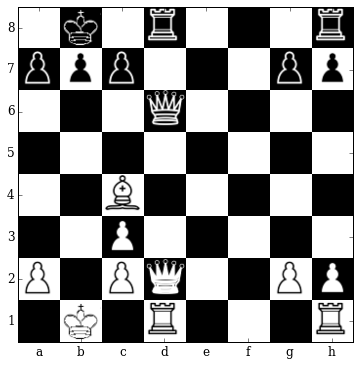

	b2c3 0.0228184554726


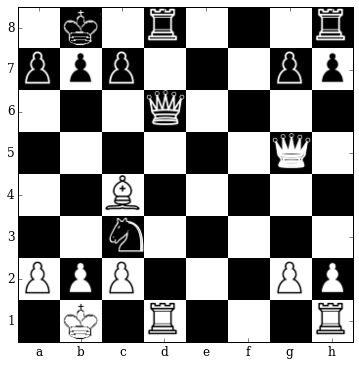

	d2g5 0.0207833554596
WORST 5 Moves


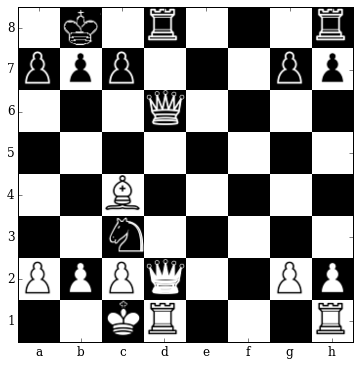

	b1c1 -0.0201652310789


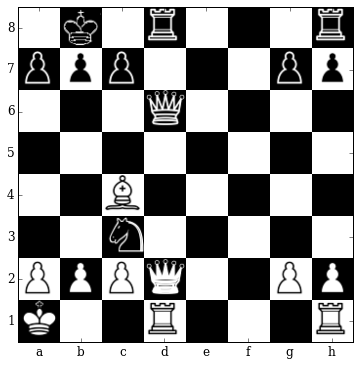

	b1a1 -0.0206535439938


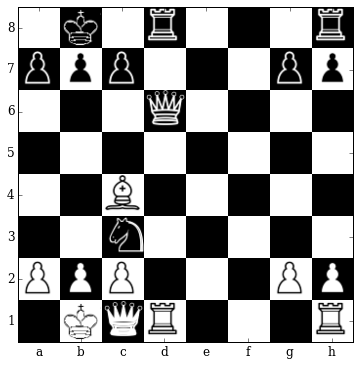

	d2c1 -0.0241448543966


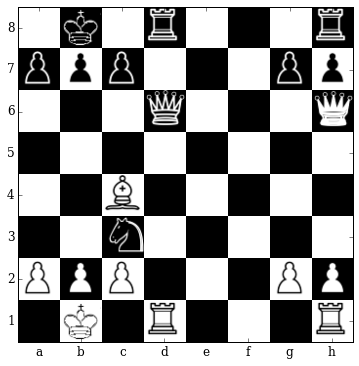

	d2h6 -0.0248840861022


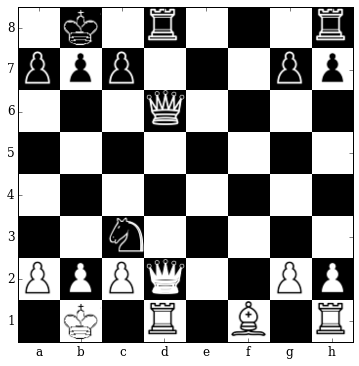

	c4f1 -0.0262713693082


In [19]:
'''
Check and fork by the knight
'''
fen='1k1r3r/ppp3pp/3q4/8/2B5/2n5/PPPQ2PP/1K1R3R w - - 0 0'
top_bottom_moves(fen)

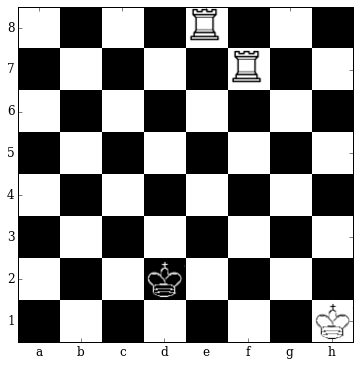

	Current evaluation: 0.227653
Total 31 moves possible
TOP 5 Moves


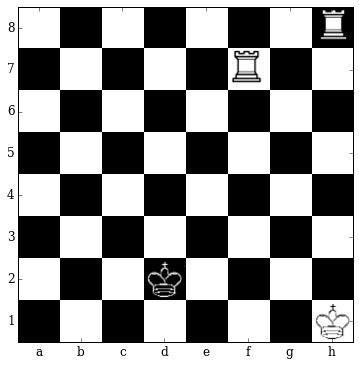

	e8h8 0.307574003935


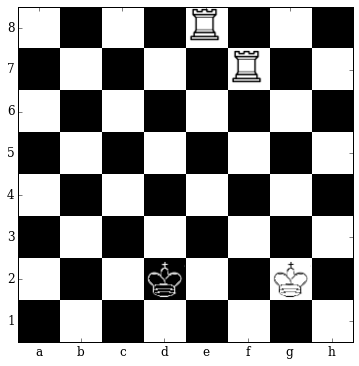

	h1g2 0.279015421867


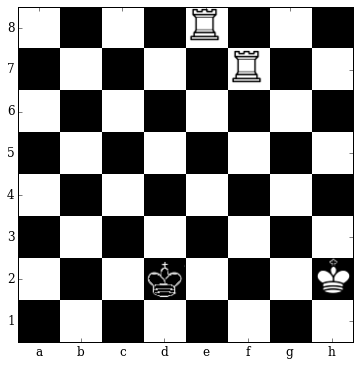

	h1h2 0.25475075841


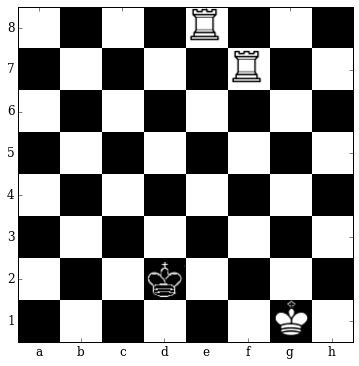

	h1g1 0.244157657027


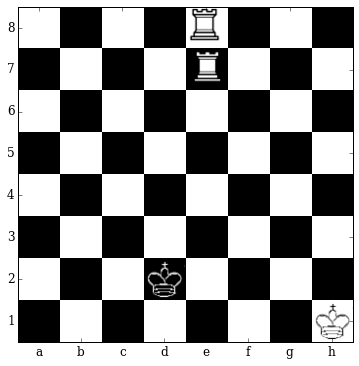

	f7e7 0.242229655385
WORST 5 Moves


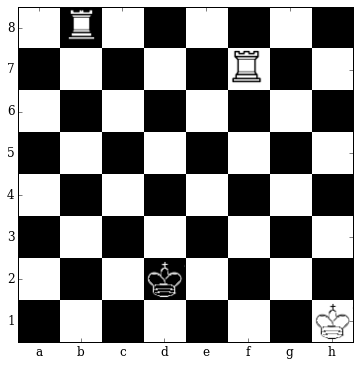

	e8b8 0.180342525244


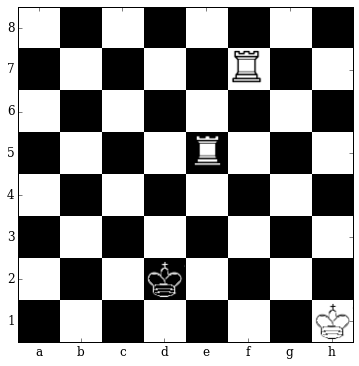

	e8e5 0.179203212261


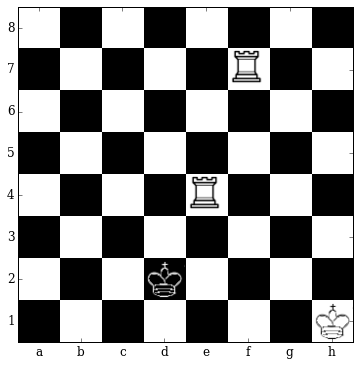

	e8e4 0.179086685181


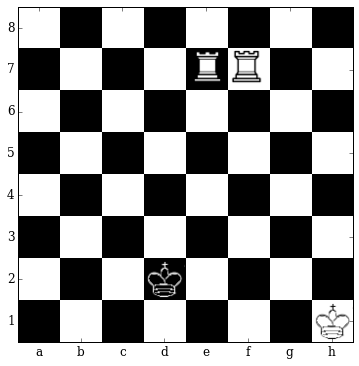

	e8e7 0.178259670734


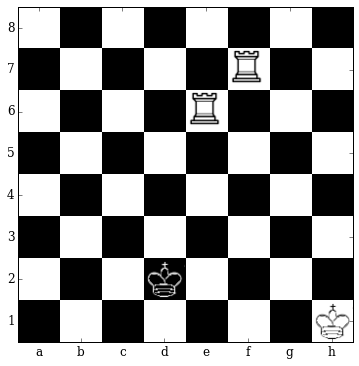

	e8e6 0.162149891257


In [20]:
'''
Pushing the broom
'''
fen='4R3/5R2/8/8/8/8/3k4/7K w - - 0 0'
top_bottom_moves(fen)

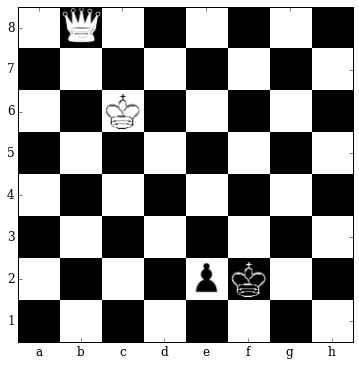

	Current evaluation: 0.132124
Total 29 moves possible
TOP 5 Moves


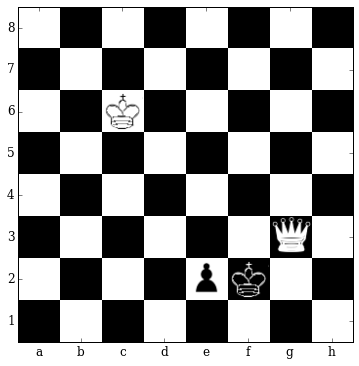

	b8g3 0.232341885567


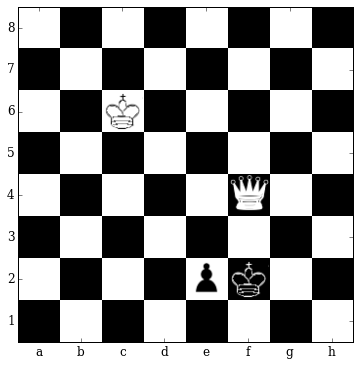

	b8f4 0.220576122403


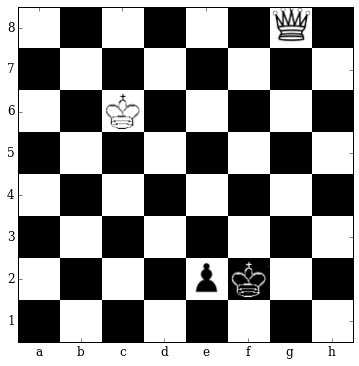

	b8g8 0.212574183941


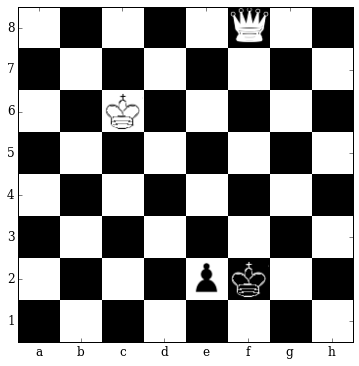

	b8f8 0.208147808909


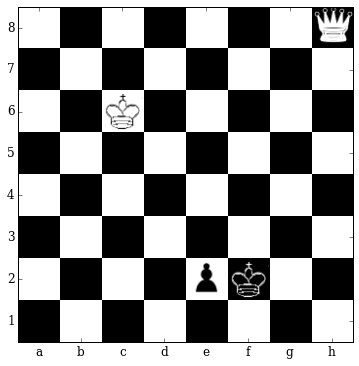

	b8h8 0.205039218068
WORST 5 Moves


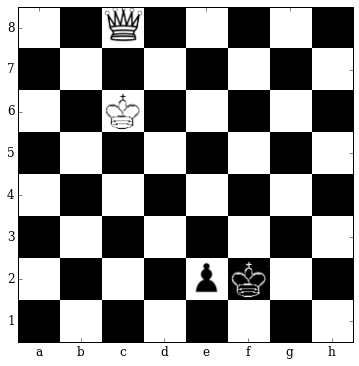

	b8c8 0.131534919143


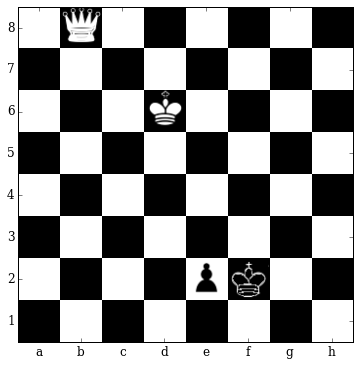

	c6d6 0.129832103848


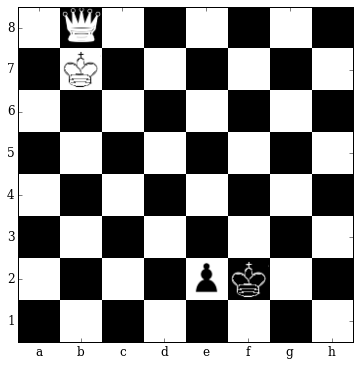

	c6b7 0.121259056032


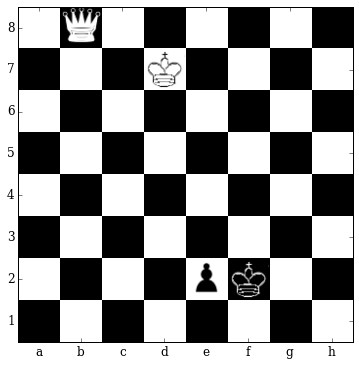

	c6d7 0.109470196068


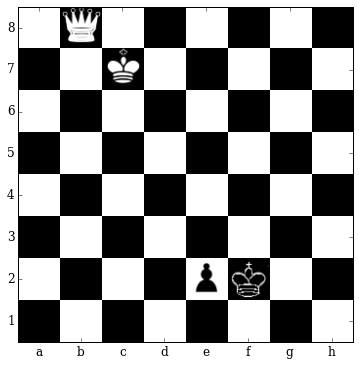

	c6c7 0.105199843645


In [21]:
'''
Queen King vs King Pawn
'''
fen = '1Q6/8/2K5/8/8/8/4pk2/8 w - - 0 0'
top_bottom_moves(fen)

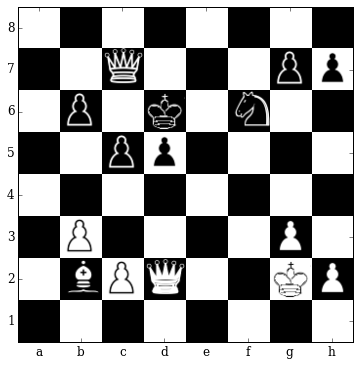

	Current evaluation: -0.022609
Total 34 moves possible
TOP 5 Moves


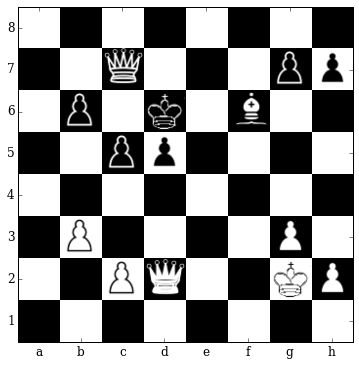

	b2f6 0.0331075526774


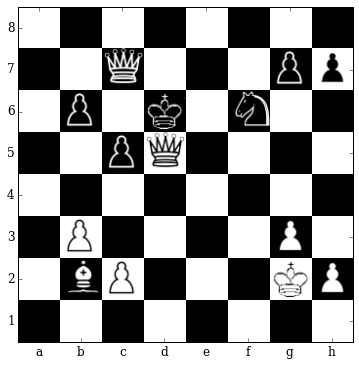

	d2d5 0.0303655825555


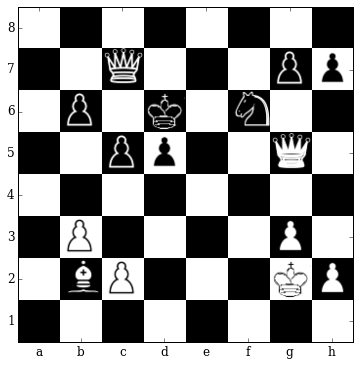

	d2g5 0.0135372653604


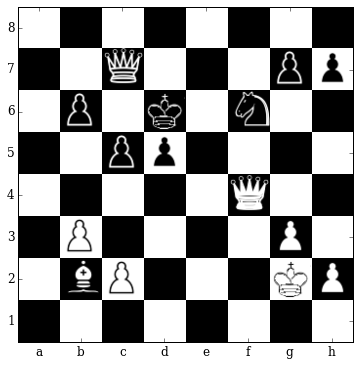

	d2f4 0.0116871418431


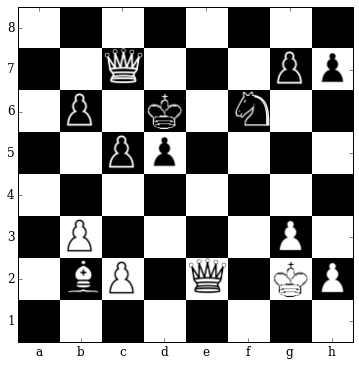

	d2e2 0.00281526707113
WORST 5 Moves


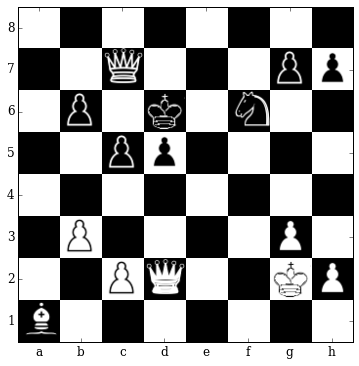

	b2a1 -0.0309130325913


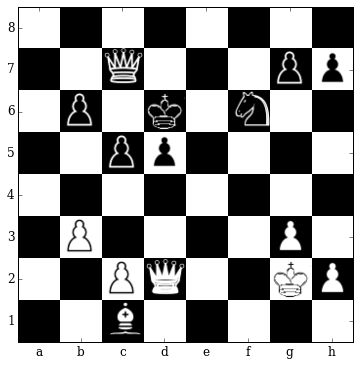

	b2c1 -0.0322335064411


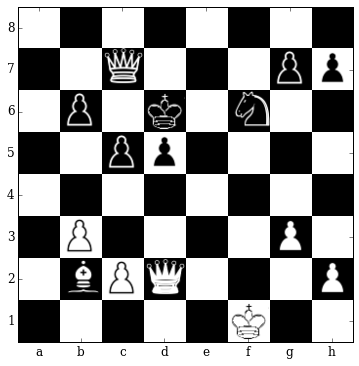

	g2f1 -0.033534001559


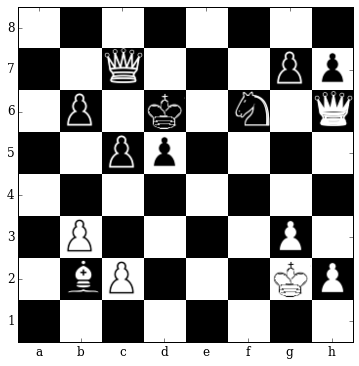

	d2h6 -0.0337856337428


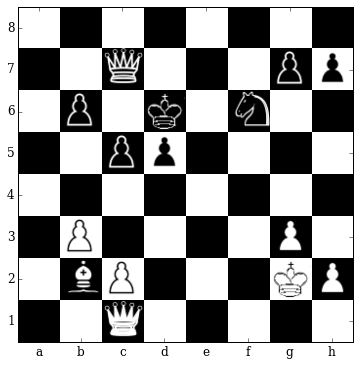

	d2c1 -0.0525860488415


In [22]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
top_bottom_moves(fen)

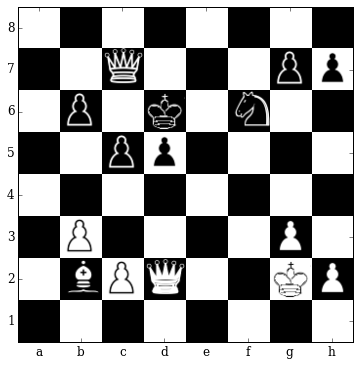

	Current evaluation: -0.022609
Total 34 moves possible
TOP 5 Moves


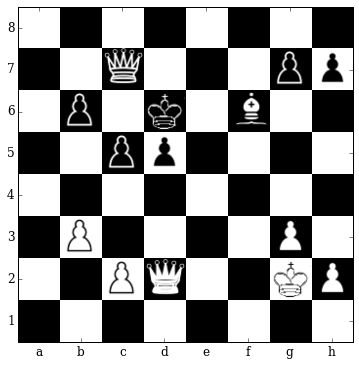

	b2f6 0.0331075526774


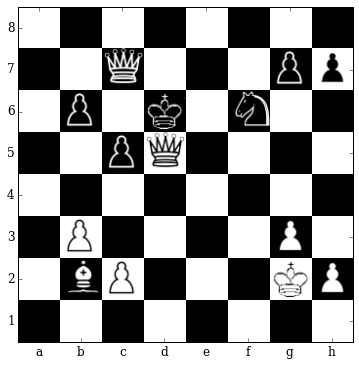

	d2d5 0.030365575105


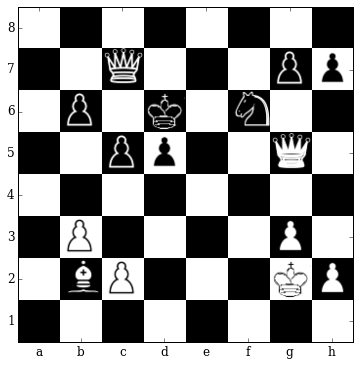

	d2g5 0.0135372653604


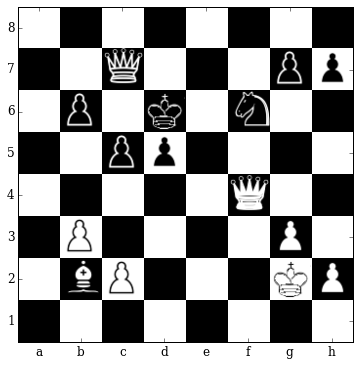

	d2f4 0.0116871567443


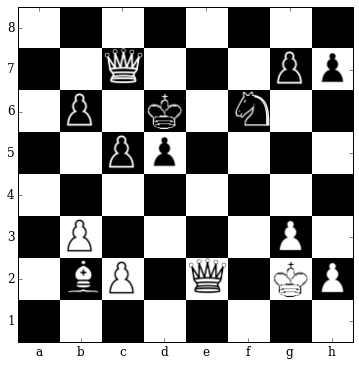

	d2e2 0.00281526707113
WORST 5 Moves


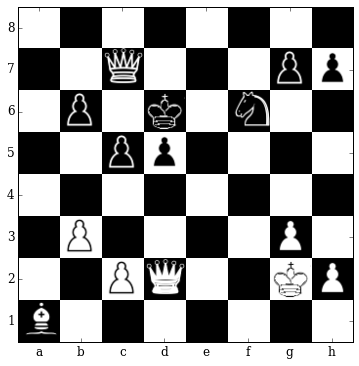

	b2a1 -0.030913002789


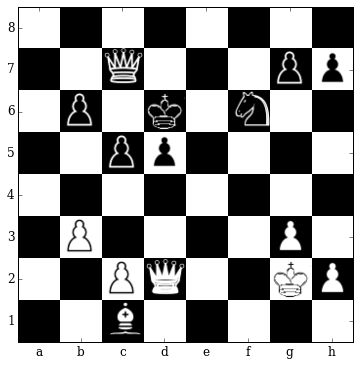

	b2c1 -0.0322335138917


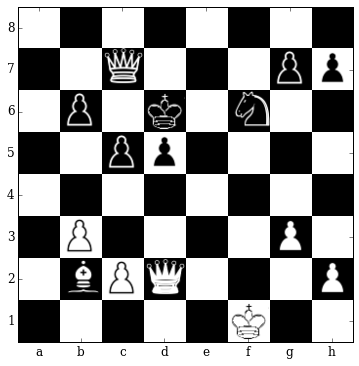

	g2f1 -0.0335339568555


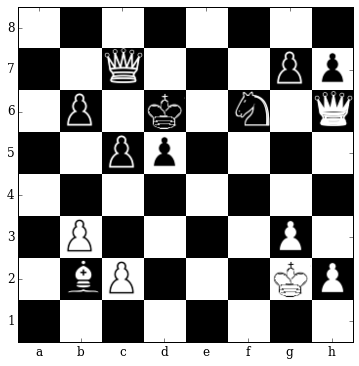

	d2h6 -0.0337856262922


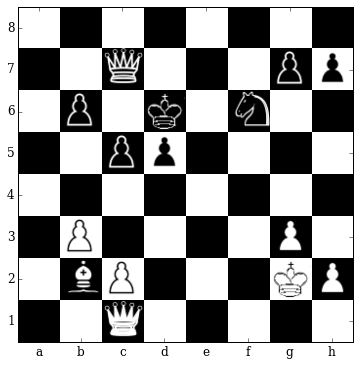

	d2c1 -0.0525860711932


In [23]:

top_bottom_moves(fen)

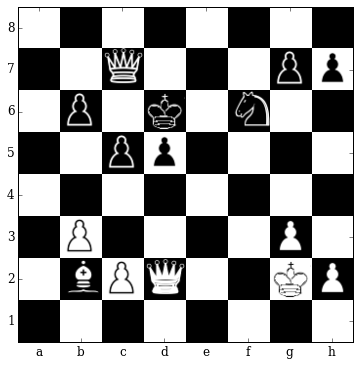

	Current evaluation: -0.022609
Total 34 moves possible
TOP 5 Moves


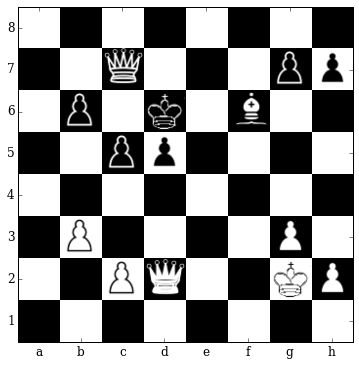

	b2f6 0.0331075526774
WORST 5 Moves


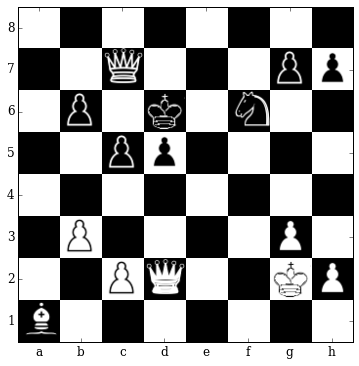

	b2a1 -0.0309130176902


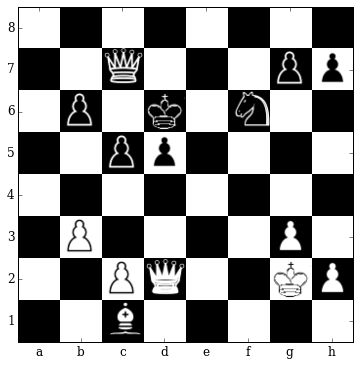

	b2c1 -0.0322334840894


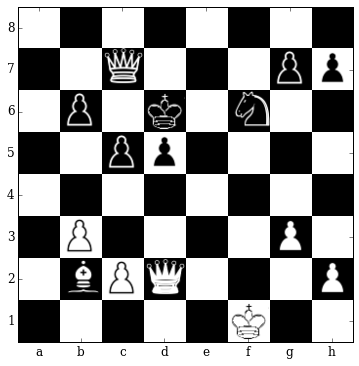

	g2f1 -0.0335339941084


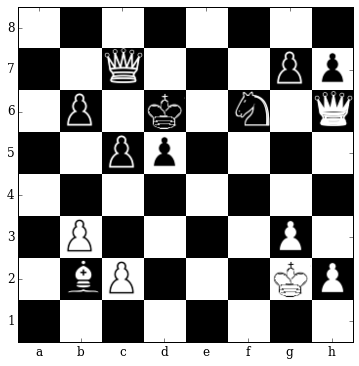

	d2h6 -0.0337856411934


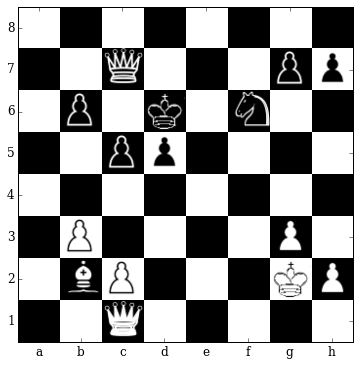

	d2c1 -0.0525860711932
                   
 ........
 ..q...pp
 .p.k.n..
 ..pp....
 ........
 .P....P.
 .BPQ..KP
 ........ 
                   
-0.0226090531796


KeyError: 'p'

In [24]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
move = top_bottom_moves(fen, 1)
pos = parseFEN(fen)
print pos.board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.board), 2, 0))
move= "c5e5"
crdn = (sunfish.parse(move[0:2]), sunfish.parse(move[2:4]))
print pos.move(crdn).rotate().board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).rotate().board), 2, 0))
print pos.move(crdn).board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).board), 2, 0))


In [14]:
import h5py as h5
y = h5.File("/data/ConvChess/data/")
y = y['label']

In [15]:
y = y[0:1000000]
print np.std(y)
print np.var(y)

0.200632
0.0402531


In [16]:
#evaluator = CNN_evaluator('regression_models/model_CvC_g09.pkl')

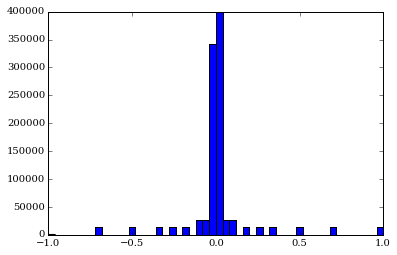

In [17]:
%matplotlib inline
import matplotlib.cm as cm
plt.hist(y, bins=50)
plt.show()

In [12]:
import time
tables = np.load("/data/ConvChess/data/fics_regression_g07/X_80000_88000.npz")
tables = tables['arr_0']
print "Number of tables: %d"%len(tables)
start = time.time()
evaluations = evaluator.evaluate_batch(tables)
tablevals = np.zeros(tables.shape[0])
for i, table in enumerate(tables):
    tablevals[i] = im_to_tableval(table)
end = time.time()
print np.corrcoef(evaluations, tablevals)
print "Time taken: %f"%(end-start)

Number of tables: 665727
[[ 1.          0.80631838]
 [ 0.80631838  1.        ]]
Time taken: 16.174644


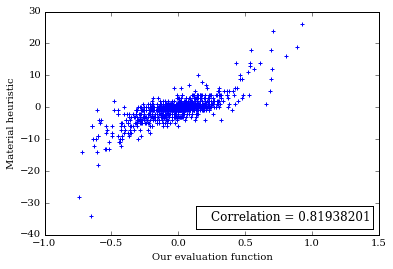

In [19]:
eval1 = evaluations[::500]
eval2 = tablevals[::500]
plt.scatter(eval1, eval2, color='b', marker='+')
plt.rc('text', usetex=False)
plt.ylabel("Material heuristic")
plt.xlabel("Our evaluation function")
from matplotlib.patches import Rectangle
leg1 = Rectangle((0, 0), 0, 0, alpha=0.0)
plt.legend([leg1], ['Correlation = 0.81938201'], handlelength=0,
          loc=4)
# plt.text(0.78, -35, 'Correlation = 0.81938201',
#         verticalalignment='bottom', horizontalalignment='right',
#         color='black', fontsize=14)
plt.show()

In [66]:
%matplotlib inline

In [63]:
np.where(tablevals[:1000]!=0)

(array([ 21,  26,  44,  48,  50,  52,  53,  54,  55,  56,  57,  58,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76, 106, 112, 115, 116,
        117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
        183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
        196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 212, 214,
        215, 216, 217, 218, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 258, 259, 260, 263, 264,
        265, 273, 280, 284, 286, 291, 307, 309, 312, 313, 314, 323, 327,
        328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
        341, 342, 343, 344, 353, 356, 360, 368, 370

In [68]:
def compare_evals(im):
    im_to_boardimage(im)
    print evaluator.evaluate(im)
    print im_to_tableval(im)

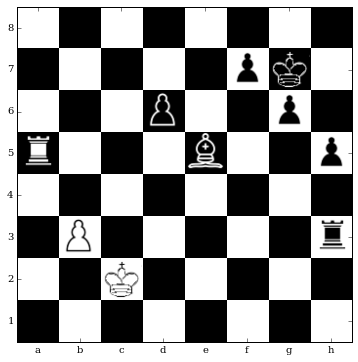

-0.0748723372817
-6.0


In [69]:
compare_evals(tables[971])

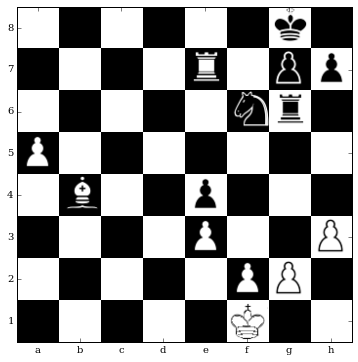

0.0902274101973
2.0


In [76]:
compare_evals(tables[811])

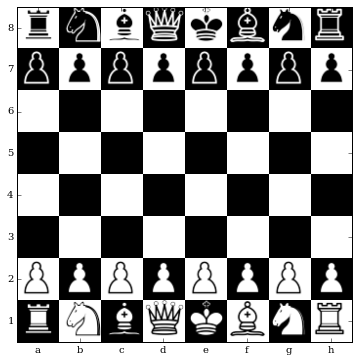

0.00157964101527
0.0


In [77]:
compare_evals(tables[0])

In [35]:
tables = np.load("/data/ConvChess/data/test_npz/X_0_104.npz")
tables = tables['arr_0']
table_evals = np.load("/data/ConvChess/data/test_npz/y_0_104.npz")
table_evals = table_evals['arr_0']

In [36]:
table_evals[269:269+81]
print table_evals.shape

(9504,)


In [37]:
import theano
model = evaluator.model
get_activations = theano.function([model.layers[0].input], model.layers[8].get_output(train=False), allow_input_downcast=True)

In [38]:
tables= tables[0:10000]
table_evals = table_evals[0:10000]
activations = get_activations(tables)
print activations.shape
activations = np.asfarray(activations, dtype='float')

(9504, 256)


Number of points: 9504
TSNE running
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 9504
[t-SNE] Computed conditional probabilities for sample 2000 / 9504
[t-SNE] Computed conditional probabilities for sample 3000 / 9504
[t-SNE] Computed conditional probabilities for sample 4000 / 9504
[t-SNE] Computed conditional probabilities for sample 5000 / 9504
[t-SNE] Computed conditional probabilities for sample 6000 / 9504
[t-SNE] Computed conditional probabilities for sample 7000 / 9504
[t-SNE] Computed conditional probabilities for sample 8000 / 9504
[t-SNE] Computed conditional probabilities for sample 9000 / 9504
[t-SNE] Computed conditional probabilities for sample 9504 / 9504
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 81 iterations with early exaggeration: 78.830153
[t-SNE] Error after 343 iterations: 4.905942
TSNE took 2.7e+03 sec


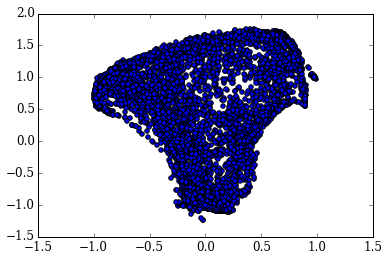

In [44]:
from time import time
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, TSNE
print "Number of points:",len(activations)
print "TSNE running"
t0 = time()
Y1 = TSNE(verbose=1, early_exaggeration=10.0, learning_rate=200).fit_transform(activations)
t1 = time()
print("TSNE took %.2g sec" % (t1 - t0))
#colors = cm.rainbow(np.linspace(0, 1, 64))
#for i in xrange(Y1.shape[0]):
plt.scatter(Y1[:,0],Y1[:,1], cmap=cm.gray)# color= colors[piece_types[i]])
#plt.legend()
plt.show()

In [105]:
#scaled_z = (vals - vals.min()) / vals.ptp()
cm = plt.cm.get_cmap('seismic')
ax = plt.scatter(Y1[:,0],Y1[:,1], c=vals, cmap=cm)
plt.plot(Y1[1596:1810:2,0], Y1[1596:1810:2,1 ], '^y-', linewidth=2, label='Loser')
plt.plot(Y1[1597:1810:2,0], Y1[1597:1810:2,1 ], '^c-', linewidth=2, label='Winner')
plt.legend(loc='upper left', shadow=True)
plt.colorbar(ax)
plt.show()

In [39]:
vals = evaluator.evaluate_batch(tables)

In [46]:
%matplotlib qt

In [104]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

NameError: name 'display_animation' is not defined

In [97]:
1558+38+214


1810

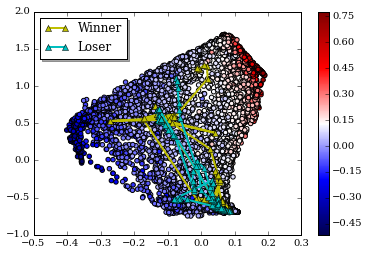

In [221]:
%matplotlib inline
#table_evals[993:1179]
#scaled_z = (vals - vals.min()) / vals.ptp()
cm = plt.cm.get_cmap('seismic')
ax = plt.scatter(Y1[:,0],Y1[:,1], c=vals, cmap=cm)
plt.plot(Y1[993:1179:2,0], Y1[993:1179:2,1 ], '^y-', linewidth=2, label='Winner')
plt.plot(Y1[994:1179:2,0], Y1[994:1179:2,1 ], '^c-', linewidth=2, label='Loser')
plt.legend(loc='upper left', shadow=True)
plt.colorbar(ax)
plt.show()

In [66]:
#number of parameters
sum = 0
for j in xrange(len(params[0])):
    prod=1
    for lol in params[0][j].get_value().shape:
        prod = prod*lol
    sum+=prod
print sum

26288929


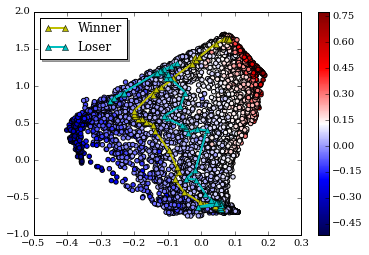

In [162]:
#table_evals[254:499]
cm = plt.cm.get_cmap('seismic')
ax = plt.scatter(Y1[:,0],Y1[:,1], c=vals, cmap=cm)
plt.plot(Y1[254:345:2,0], Y1[254:345:2,1 ], '^y-', linewidth=2, label='Winner')
plt.plot(Y1[255:345:2,0], Y1[255:345:2,1 ], '^c-', linewidth=2, label='Loser')
plt.legend(loc='upper left', shadow=True)
plt.colorbar(ax)
plt.show()

In [155]:
cm = plt.cm.get_cmap('seismic')
ax = plt.scatter(Y1[:,0],Y1[:,1], c=vals, cmap=cm)
plt.plot(Y1[346:499:2,0], Y1[346:499:2,1 ], '^y-', linewidth=2, label='Winner')
plt.plot(Y1[347:499:2,0], Y1[347:499:2,1 ], '^c-', linewidth=2, label='Loser')
plt.legend(loc='upper left', shadow=True)
plt.colorbar(ax)
plt.show()

The game is 46 moves long


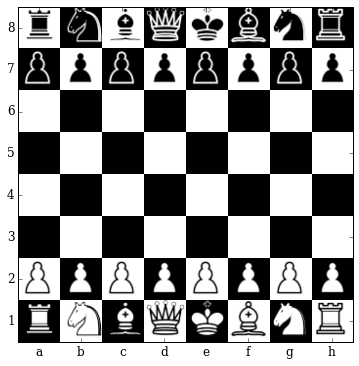

0.0146063016728


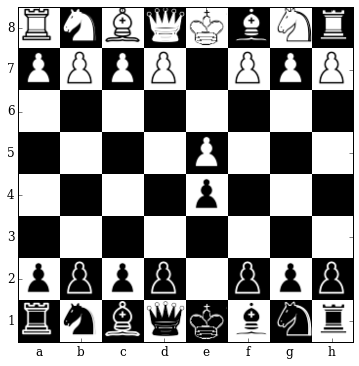

0.165879771113


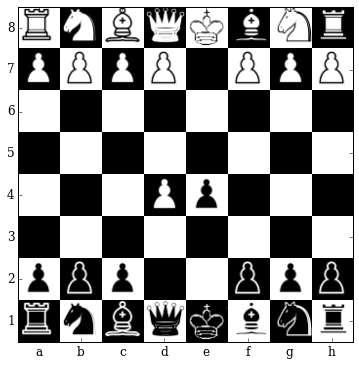

0.174223974347


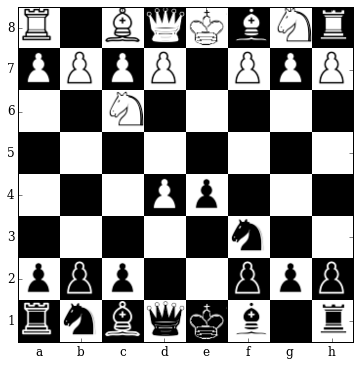

0.17188835144


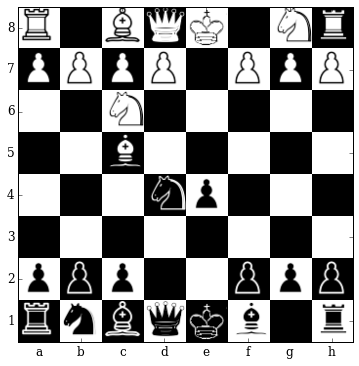

0.167817786336


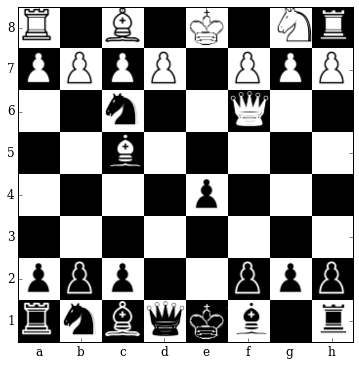

0.143943607807


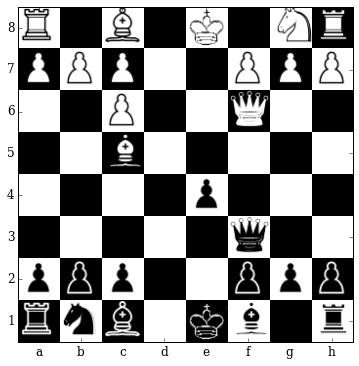

0.152258709073


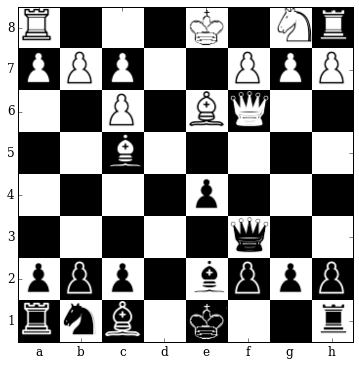

0.144029840827


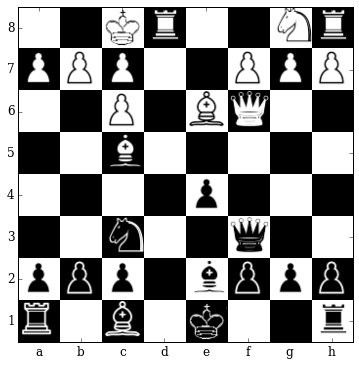

0.124352350831


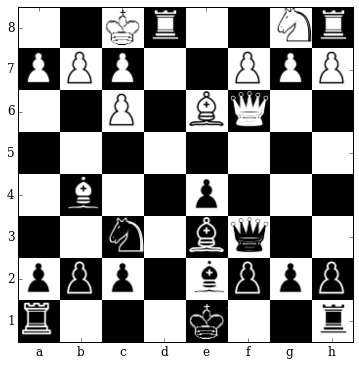

0.0764660015702


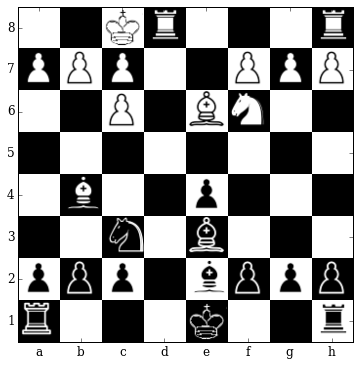

0.133716151118


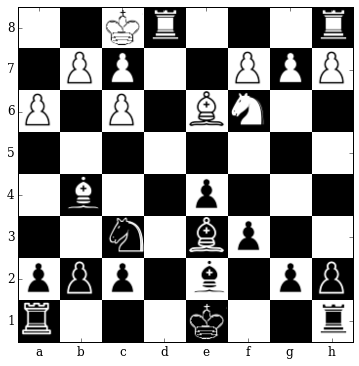

0.139131367207


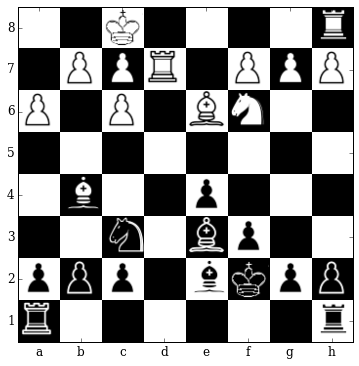

0.135214671493


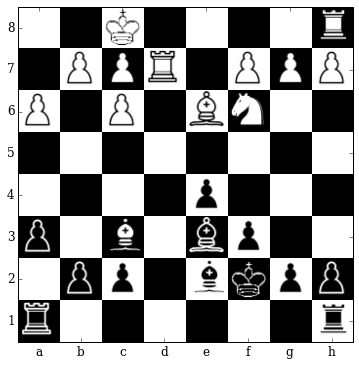

0.160677343607


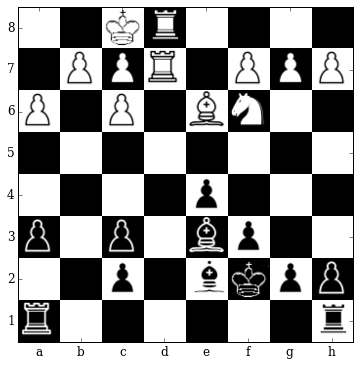

0.150639608502


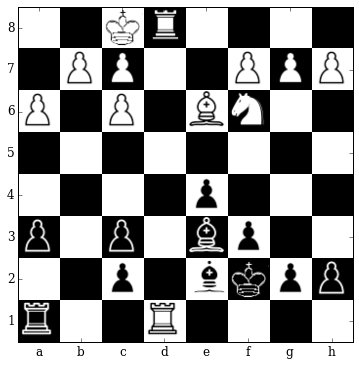

0.178551226854


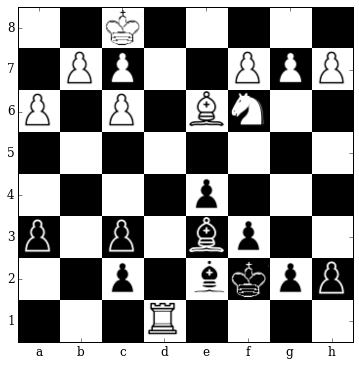

0.165853559971


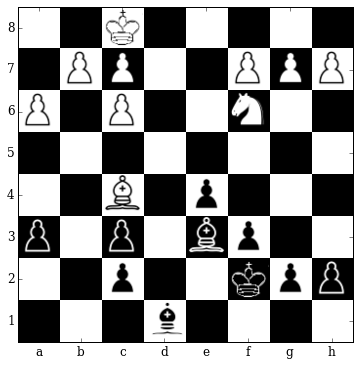

0.13951086998


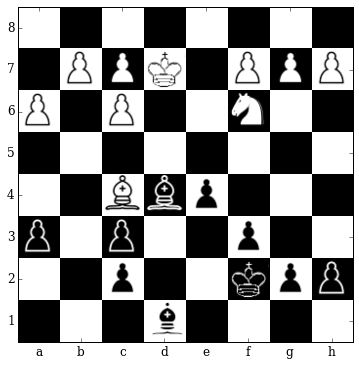

0.141461014748


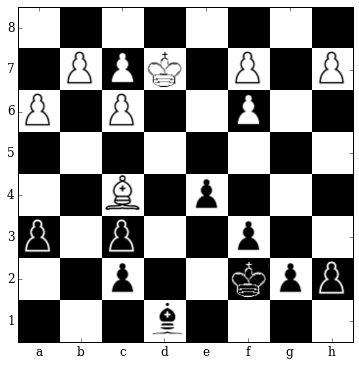

0.163480043411


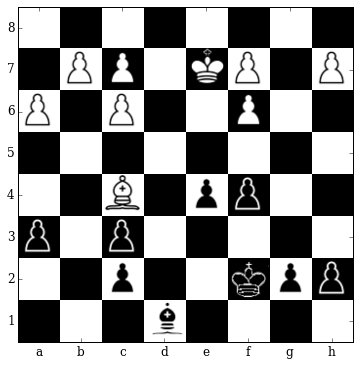

0.165383860469


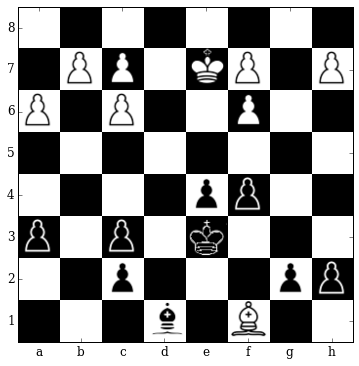

0.156563252211


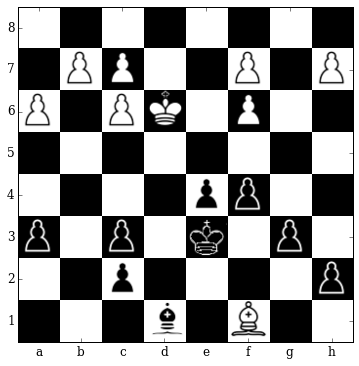

0.154383823276


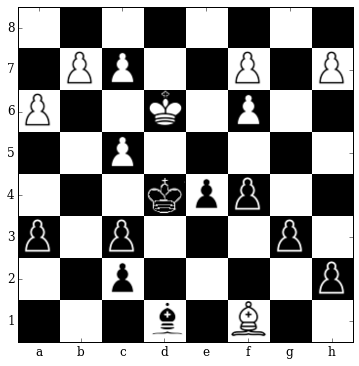

0.158842280507


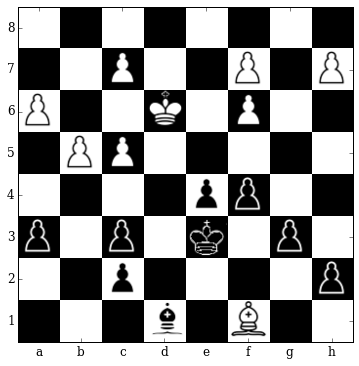

0.146308466792


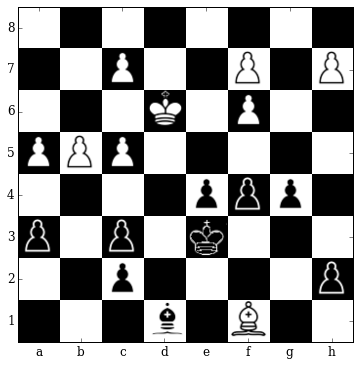

0.146699845791


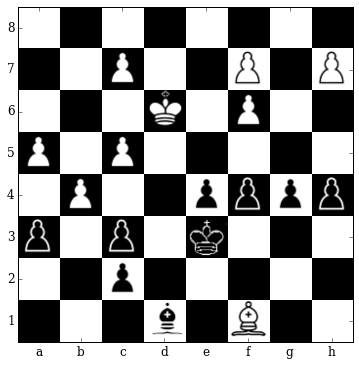

0.153887212276


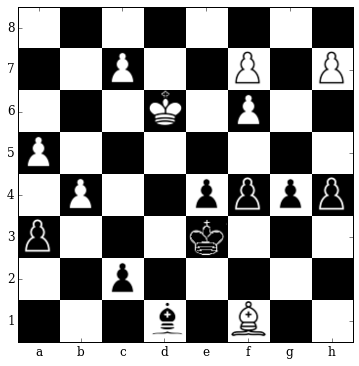

0.148539885879


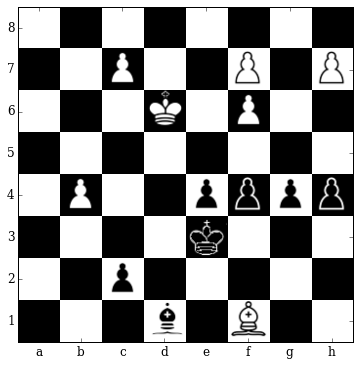

0.144471213222


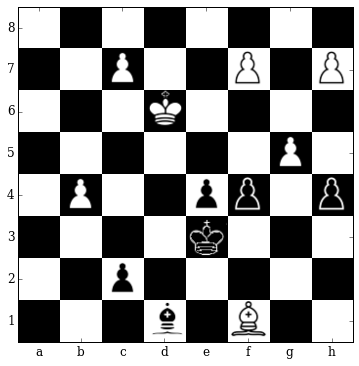

0.145277559757


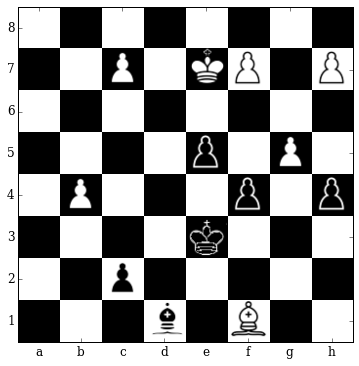

0.150925561786


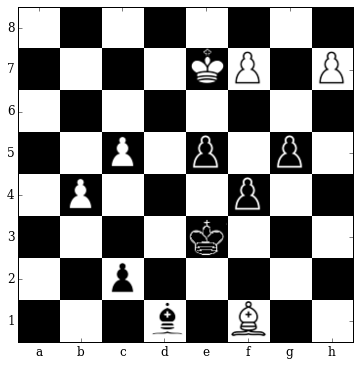

0.103720732033


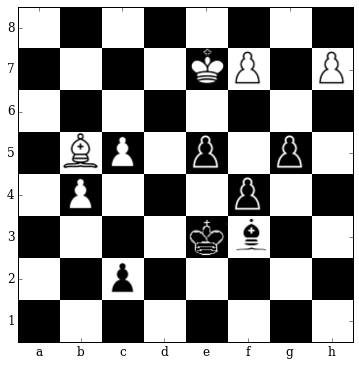

0.111814804375


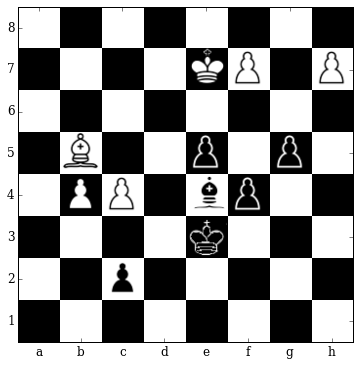

0.112260125577


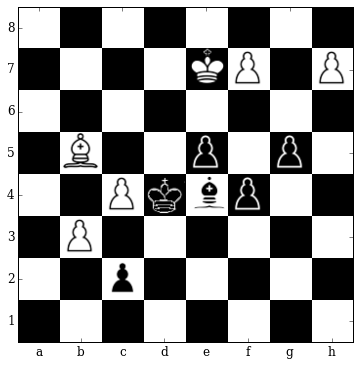

0.0942284837365


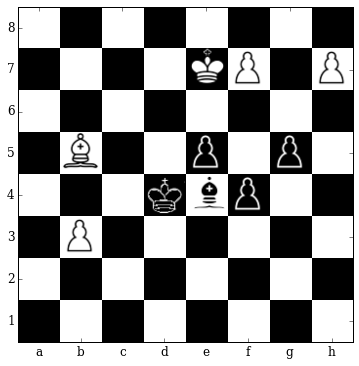

0.100209102035


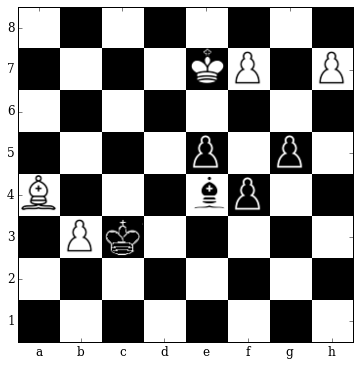

0.0653503090143


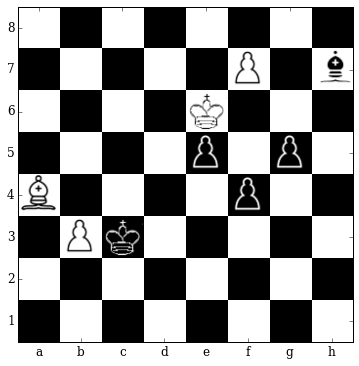

0.054747864604


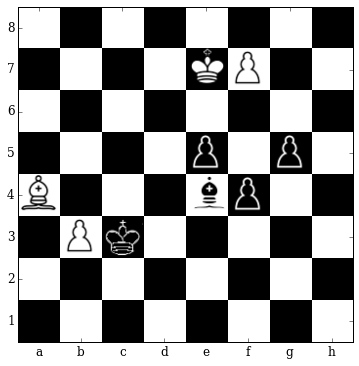

0.0299388412386


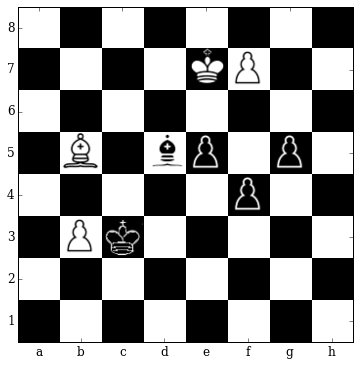

0.041055932641


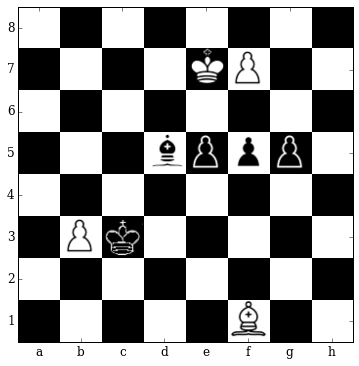

0.00148673250806


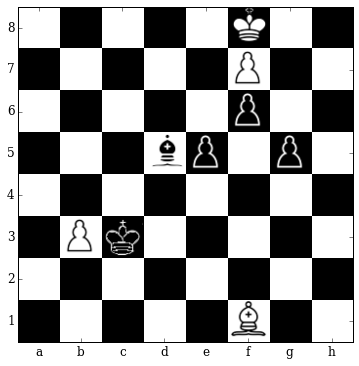

-0.0371554456651


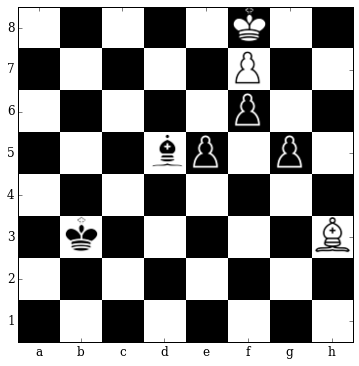

-0.054861497134


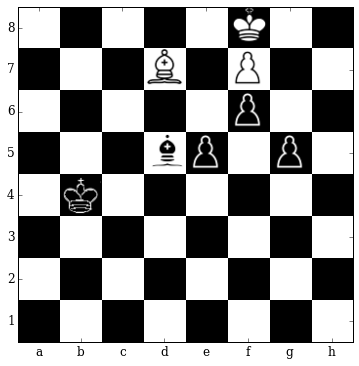

-0.0537332966924


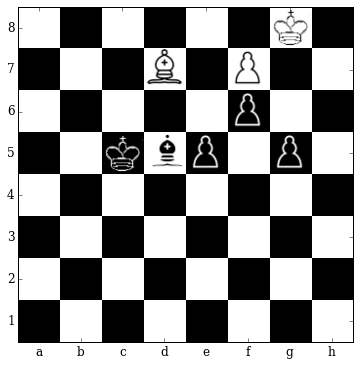

-0.0382675416768


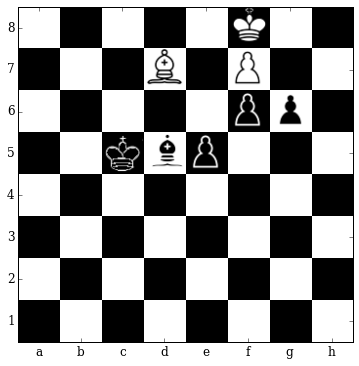

-0.0716468468308


In [258]:
game = tables[254:345:2]
print "The game is %d moves long"%game.shape[0]
for board in game:
    im_to_boardimage(board)
    print evaluator.evaluate(board)

1.07007e-07


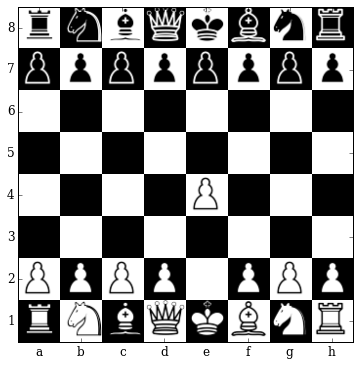

In [238]:
print table_evals[254]
im_to_boardimage(flip_color_1(game[1][:,::-1,:]))